In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tensorflow import keras
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau

from tensorflow.keras import layers

import warnings
warnings.filterwarnings("ignore")

2021-10-19 06:42:41.679244: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory('../input/face-expression-datasets/datasets/Training', validation_split=0.2, subset="training", shuffle=True, seed = 2021, labels='inferred', batch_size=32, image_size=(48,48))
val_ds = tf.keras.preprocessing.image_dataset_from_directory('../input/face-expression-datasets/datasets/Training', validation_split=0.2, subset="validation", shuffle=True, seed = 2021, labels='inferred', batch_size=32, image_size=(48,48))

Found 28273 files belonging to 6 classes.
Using 22619 files for training.


2021-10-19 06:42:55.180145: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-19 06:42:55.181340: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-19 06:42:55.208928: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-19 06:42:55.209564: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-19 06:42:55.209613: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-19 06:42:55.212064: I tensorflow/stream_executor/platform/def

Found 28273 files belonging to 6 classes.
Using 5654 files for validation.


In [3]:
class_names = train_ds.class_names

2021-10-19 06:42:57.996226: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-19 06:42:57.997390: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000179999 Hz


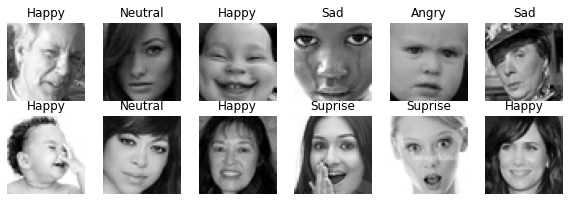

In [4]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 48, 48, 3)
(32,)


In [6]:
image_batch, labels_batch = next(iter(train_ds))
image_batch[0]

<tf.Tensor: shape=(48, 48, 3), dtype=float32, numpy=
array([[[173., 173., 173.],
        [103., 103., 103.],
        [101., 101., 101.],
        ...,
        [123., 123., 123.],
        [ 81.,  81.,  81.],
        [ 77.,  77.,  77.]],

       [[175., 175., 175.],
        [ 97.,  97.,  97.],
        [100., 100., 100.],
        ...,
        [107., 107., 107.],
        [ 86.,  86.,  86.],
        [ 88.,  88.,  88.]],

       [[193., 193., 193.],
        [123., 123., 123.],
        [111., 111., 111.],
        ...,
        [126., 126., 126.],
        [114., 114., 114.],
        [ 87.,  87.,  87.]],

       ...,

       [[145., 145., 145.],
        [145., 145., 145.],
        [146., 146., 146.],
        ...,
        [111., 111., 111.],
        [120., 120., 120.],
        [115., 115., 115.]],

       [[141., 141., 141.],
        [142., 142., 142.],
        [142., 142., 142.],
        ...,
        [103., 103., 103.],
        [115., 115., 115.],
        [114., 114., 114.]],

       [[137., 137.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
EfficientNet = tf.keras.applications.EfficientNetB0()

#EfficientNet.trainable = False

#EfficientNet.summary()

In [41]:
model = tf.keras.Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(48,48,3)))

#model.add(tf.keras.layers.Input(shape=(224, 224, 3)))
#model.add(tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal'))
#model.add(EfficientNet)

#model.add(layers.BatchNormalization())

model.add(layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"))
model.add(layers.experimental.preprocessing.RandomRotation(0.15))
model.add(layers.experimental.preprocessing.RandomZoom(0.15))

model.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu', kernel_initializer='random_normal'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='random_normal'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='random_normal', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='random_normal', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))


model.add(layers.Flatten())  

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_9 (Rescaling)      (None, 48, 48, 3)         0         
_________________________________________________________________
random_flip_8 (RandomFlip)   (None, 48, 48, 3)         0         
_________________________________________________________________
random_rotation_8 (RandomRot (None, 48, 48, 3)         0         
_________________________________________________________________
random_zoom_3 (RandomZoom)   (None, 48, 48, 3)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 48, 48, 64)        4864      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 24, 24, 64)      

In [42]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [43]:
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy',factor=0.8, patience=5, verbose=1)
save_best = tf.keras.callbacks.ModelCheckpoint("FaceExpressionModel.h5",monitor='val_accuracy',save_best_only=True, verbose=1)

**Model Training**

In [44]:
model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[lr_scheduler, save_best])

Epoch 1/100
707/707 [==============================] - 6s 7ms/step - loss: 1.7544 - accuracy: 0.2445 - val_loss: 1.7252 - val_accuracy: 0.2711

Epoch 00001: val_accuracy improved from -inf to 0.27114, saving model to FaceExpressionModel.h5
Epoch 2/100
707/707 [==============================] - 5s 6ms/step - loss: 1.7106 - accuracy: 0.2698 - val_loss: 1.6958 - val_accuracy: 0.3001

Epoch 00002: val_accuracy improved from 0.27114 to 0.30014, saving model to FaceExpressionModel.h5
Epoch 3/100
707/707 [==============================] - 5s 7ms/step - loss: 1.6671 - accuracy: 0.3040 - val_loss: 1.5954 - val_accuracy: 0.3440

Epoch 00003: val_accuracy improved from 0.30014 to 0.34400, saving model to FaceExpressionModel.h5
Epoch 4/100
707/707 [==============================] - 5s 6ms/step - loss: 1.6052 - accuracy: 0.3350 - val_loss: 1.5969 - val_accuracy: 0.3345

Epoch 00004: val_accuracy did not improve from 0.34400
Epoch 5/100
707/707 [==============================] - 5s 7ms/step - loss: 

**Load the Best Model**

In [45]:
model = keras.models.load_model('./FaceExpressionModel.h5')

**Load Test Data for Prediction**

In [46]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory('../input/face-expression-datasets/datasets/Testing', shuffle=True, seed = 2021, batch_size=16, image_size=(48,48))

Found 7067 files belonging to 6 classes.


**Class Names**

In [47]:
class_names

['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Suprise']

**Model Prediction Using Test Data**

In [48]:
model.evaluate(test_ds)

442/442 [==============================] - 11s 24ms/step - loss: 1.1144 - accuracy: 0.5739


[1.1144357919692993, 0.5739352107048035]

tf.Tensor(0, shape=(), dtype=int32)
[[1. 0. 0. 0. 0. 0.]]


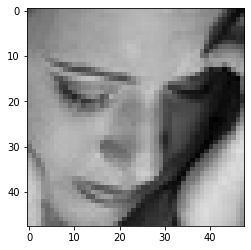

In [49]:
for x,y in test_ds:
    print(y[1])
    pred = model.predict(x[1].numpy().reshape(-1,48,48,3))
    plt.imshow(x[0].numpy().astype("uint8"))
    print(pred.round())
    break